# Transfer-Learning-Pipeline

This pipeline Contains The Implementation of 12 Transfer Learning Model.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


## Contents

### Directories

In [2]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
DATA_PATH = DATA_BASE_PATH / "splited-data"

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Variables

In [3]:
RANDOM_SEED = 42
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 64

CLASS_NAMES = sorted([img_cls for img_cls in  os.listdir(TRAIN_PATH) if img_cls != ".DS_Store"])
NUM_CLASSES = len(CLASS_NAMES)

# MODEL
MODEL_PATH = ROOT_DIR / "models"
LOG_PATH = ROOT_DIR / "log"



In [4]:
tf.random.set_seed(RANDOM_SEED)

### Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    
    horizontal_flip=True,
    
    rotation_range=30,
    
    height_shift_range=0.15,       # No need to shift the image
    width_shift_range=0.15,
    zoom_range=0.20,
    
    shear_range=0.15,              # Seems to be useful
    brightness_range=(0.7, 1.3),  # Seems to be useful
    
    validation_split=VALIDATION_SPLIT,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    )

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [14]:
train_images = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='training',
)

val_images = val_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='validation'
)


test_images = test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    
    batch_size=BATCH_SIZE,
    
    shuffle=False,
    seed=42,
)

NUM_TRAIN_IMAGES = len(train_images.filenames)
NUM_VAL_IMAGES = len(val_images.filenames)
NUM_TEST_IMAGES = len(test_images.filenames)

Found 12369 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 5186 images belonging to 120 classes.


### LOADING DATA

In [15]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    if len(y.shape) == 2:
        y = y.argmax(axis=1)
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"\n*({labels[i]})*"
        plt.title(title)
        plt.axis("off")
        # increase vertical space between subplots
        plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    

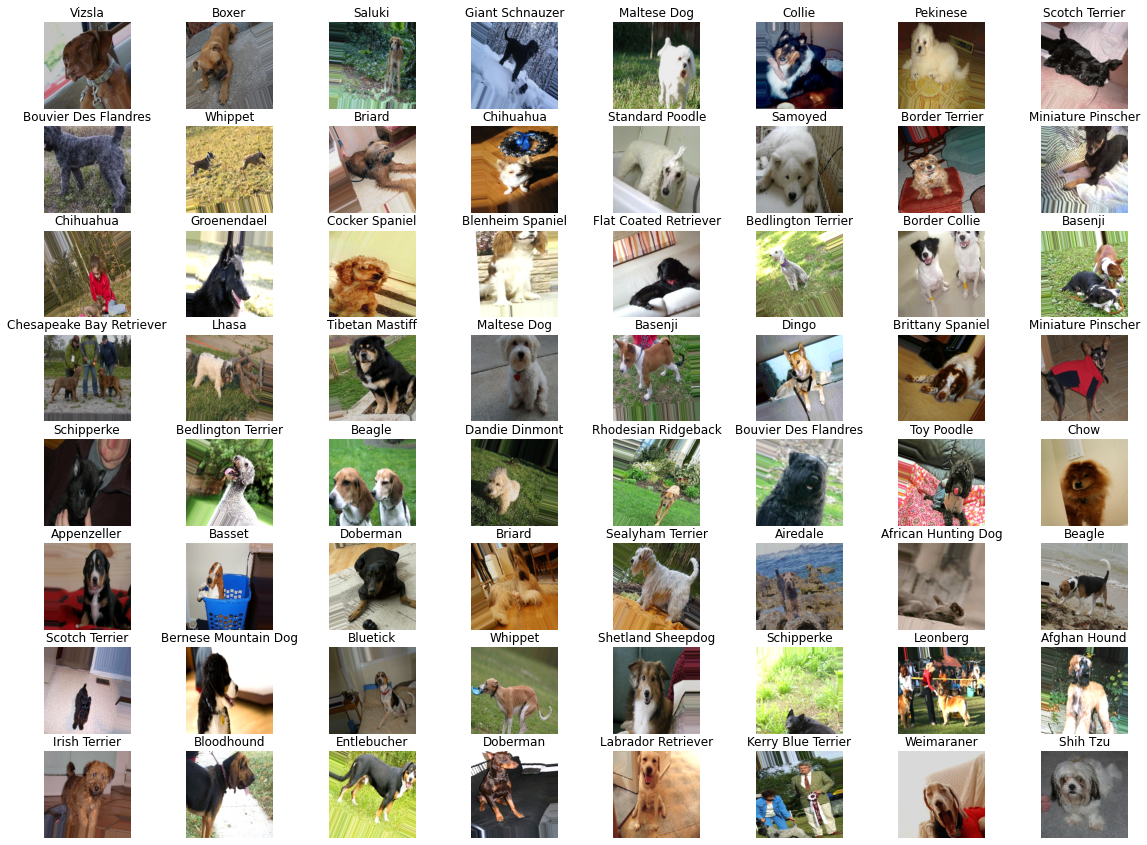

In [16]:
num_rows = 8
num_cols = 8

plt.figure(figsize=(20, 15))

images, labels = train_images.next()
for i in range(num_cols * num_rows):
    plt.subplot(num_cols, num_rows, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

## Model

In [17]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, log_loss


### Valribles

In [18]:
INPUT_SHAPE = train_images.next()[0][0].shape
TRAIN_MODELS = True
TRAIN_MODELS = False


### Useful functions ###

In [19]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


# def get_model_performance(y_true, y_pred):
#     if len(y_true.shape) == 2:
#         y_true = y_true.argmax(axis=1)
#     if len(y_pred.shape) == 2:
#         y_pred = y_pred.argmax(axis=1)

#     accuracy = accuracy_score(y_true, y_pred)
#     # top_5_accuracy = top_k_categorical_accuracy(y_true, y_pred, k=5)
#     f1_scr = f1_score(y_true, y_pred, average='weighted')
#     precision_scr = precision_score(y_true, y_pred, average='weighted')
#     recall_scr = recall_score(y_true, y_pred, average='weighted')
    
    
#     performance = {
#         "Accuracy": accuracy,
#         # "top-5-accuracy": top_5_accuracy,
#         "F1 Score": f1_scr,
#         "Precision": precision_scr,
#         "Recall": recall_scr
#     }
    
#     return performance
def compute_performance_metrics(y, y_pred, verbose=1):
    # labels = test_images_.y.argmax(axis=1)
    labels = y
    labels_cat = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    # pred_cat = model.predict(test_images_)
    pred_cat = y_pred
    pred = pred_cat.argmax(axis=1)

    
    performance_metrics = {}
    performance_metrics["accuracy"] = round(accuracy_score(labels, pred), 4)
    performance_metrics["top_5_accuracy"] = round(top_k_categorical_accuracy(labels_cat, pred_cat, k=5).numpy().sum() / len(y), 4)
    performance_metrics["f1_score"] = round(f1_score(labels, pred, average="macro"), 4)
    performance_metrics["precision"] = round(precision_score(labels, pred, average="macro"), 4)
    performance_metrics["recall"] = round(recall_score(labels, pred, average="macro"), 4)
    performance_metrics["loss"] = round(log_loss(labels_cat, pred_cat), 4)
    
    performance_df.loc[model.name] = performance_metrics
    if verbose:
        return performance_df.loc[model.name]

performance_df = pd.DataFrame(columns=["accuracy", "top_5_accuracy", "precision", "recall", "f1_score", "loss"])


### MODELS

#### MODEL ARCHITECTURE

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications

weight_decay = 25e-6
LEARNING_RATE = 4e-4
learning_rate_decay_rate = 0.05

def create_model(model_backbone: str, model_name:str=None, layers=[256]):
    model_name = model_name or model_backbone
    model_name = f"{model_name}-Fully-Trained"
    model = Sequential(name=model_name)
    
    model_backbone = get_model_backbone(model_backbone)
    model.add(model_backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.2))
    
    for layer_size in layers:
        model.add(Dense(layer_size, kernel_regularizer=l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(0.3))
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

def get_model_backbone(model_backbone: str):
    if model_backbone == "VGG16":
        model_backbone = applications.VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "VGG19":
        model_backbone = applications.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet50V2":
        model_backbone = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet101V2":
        model_backbone = applications.ResNet101V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet152V2":
        model_backbone = applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionV3":
        model_backbone = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionResNetV2":
        model_backbone = applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "Xception":
        model_backbone = applications.Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet121":
        model_backbone = applications.DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet169":
        model_backbone = applications.DenseNet169(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet201":
        model_backbone = applications.DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNet":
        model_backbone = applications.MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNetV2":
        model_backbone = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
        
    return model_backbone

#### Model Training

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger


monitor_metric = 'val_accuracy'
# learning_rate_decay_rate = 0.06
def get_callbacks():
    callbacks = {}
    
    callbacks["EarlyStopping"] = EarlyStopping(
            monitor=monitor_metric,
            patience=20,
            mode = "auto",
            verbose=1,
        )
    
    callbacks["LearningRateScheduler"] = LearningRateScheduler(step_decay)

    callbacks["ModelCheckpoint"] = ModelCheckpoint(
            MODEL_PATH / f"{model.name}.h5",
            monitor=monitor_metric,
            save_best_only=True,
            mode='auto',
            verbose=1,
    )
    
    return callbacks


def step_decay(epoch):
    initial_lr = LEARNING_RATE
    k = learning_rate_decay_rate
    lr = initial_lr * np.exp(-k*epoch)
    return lr



##### VGG16

In [22]:
backbone_model = "VGG16"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                   

In [43]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

VGG16 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/VGG16.h5


82/82 [==============================] - 11s 129ms/step - loss: 3.4497 - accuracy: 0.2042 - top_k_categorical_accuracy: 0.4809


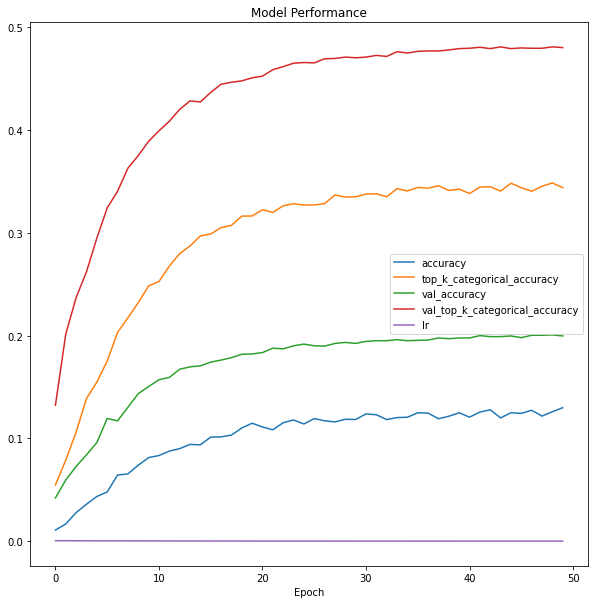

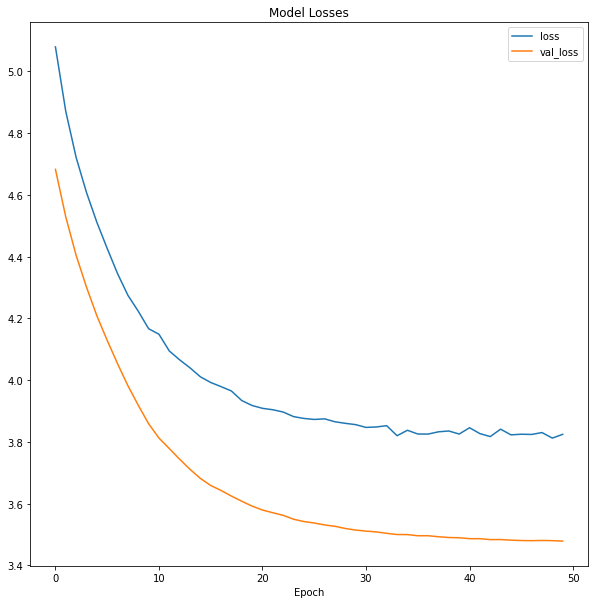

In [16]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [44]:
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, verbose=1)

/home/vineet/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy          0.2048
top_5_accuracy    0.4805
precision         0.1999
recall            0.1972
f1_score          0.1719
loss              3.4398
Name: VGG16, dtype: float64

##### VGG19

In [18]:
backbone_model = "VGG19"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

In [19]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

In [20]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [21]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

##### ResNet50V2

In [45]:
backbone_model = "ResNet50V2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 256)               0

In [46]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet50V2 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/ResNet50V2.h5


82/82 [==============================] - 7s 81ms/step - loss: 0.8477 - accuracy: 0.7516 - top_k_categorical_accuracy: 0.9520


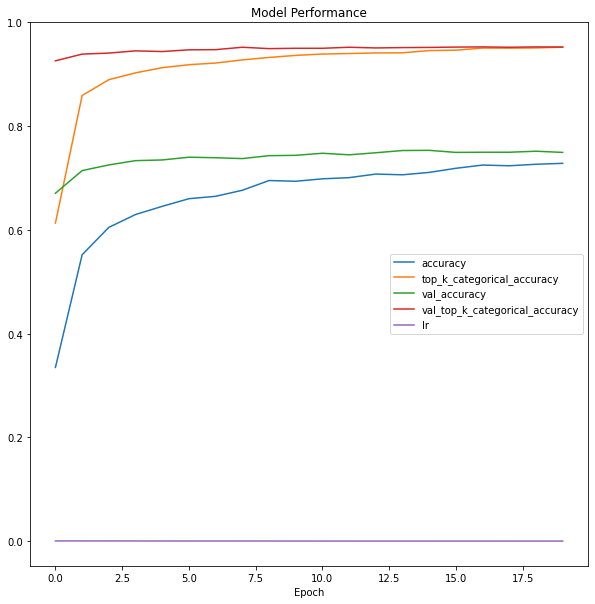

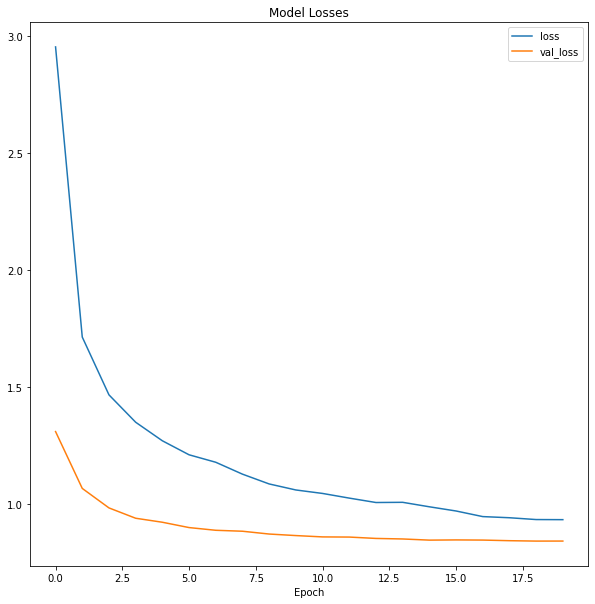

In [23]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [47]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7505
top_5_accuracy    0.9518
precision         0.7536
recall            0.7470
f1_score          0.7462
loss              0.8325
Name: ResNet50V2, dtype: float64

##### ResNet101V2

In [48]:
backbone_model = "ResNet101V2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "ResNet101V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256)               

In [49]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet101V2 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/ResNet101V2.h5


82/82 [==============================] - 10s 127ms/step - loss: 0.7736 - accuracy: 0.7707 - top_k_categorical_accuracy: 0.9589


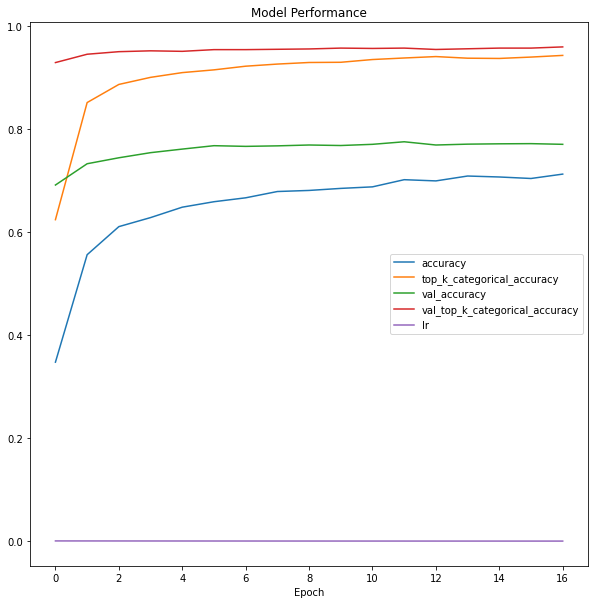

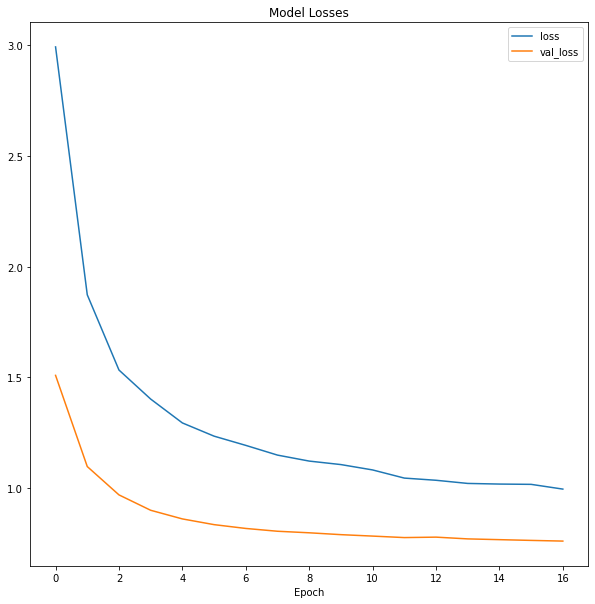

In [32]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [50]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7665
top_5_accuracy    0.9587
precision         0.7700
recall            0.7617
f1_score          0.7612
loss              0.7771
Name: ResNet101V2, dtype: float64

##### ResNet152V2

In [51]:
backbone_model = "ResNet152V2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 256)               

In [52]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

ResNet152V2 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/ResNet152V2.h5


82/82 [==============================] - 15s 184ms/step - loss: 0.7256 - accuracy: 0.7825 - top_k_categorical_accuracy: 0.9612


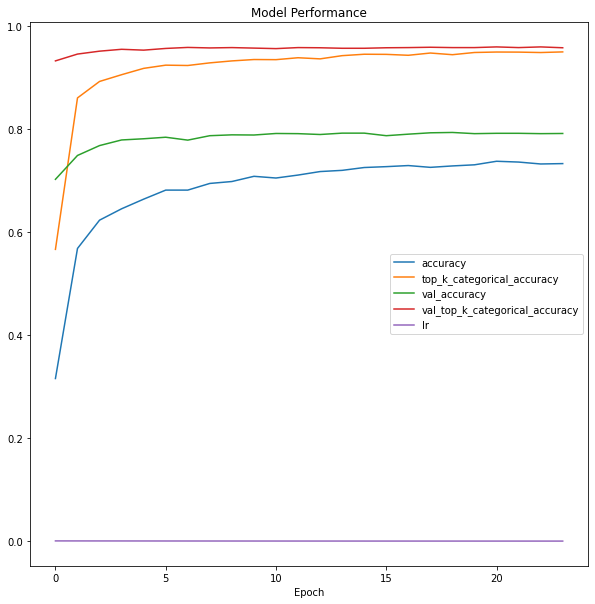

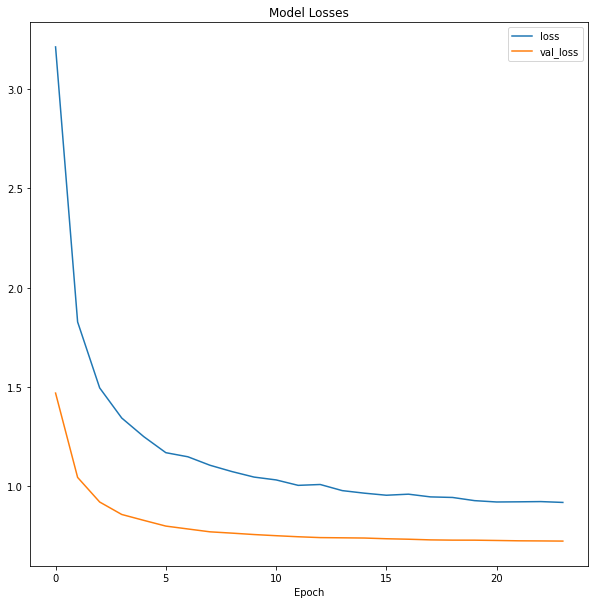

In [36]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [53]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7809
top_5_accuracy    0.9607
precision         0.7838
recall            0.7770
f1_score          0.7766
loss              0.7159
Name: ResNet152V2, dtype: float64

##### InceptionV3

In [54]:
backbone_model = "InceptionV3"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_20 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_104 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_104 (Activation)  (None, 256)              

In [55]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

InceptionV3 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/InceptionV3.h5


82/82 [==============================] - 7s 79ms/step - loss: 0.6434 - accuracy: 0.8170 - top_k_categorical_accuracy: 0.9697


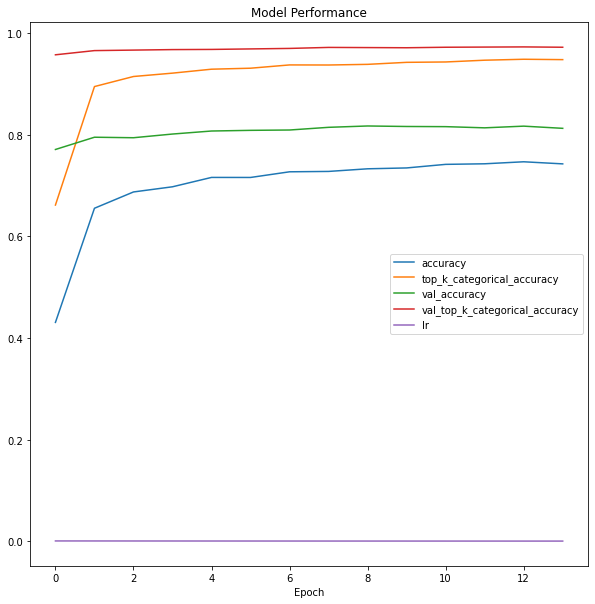

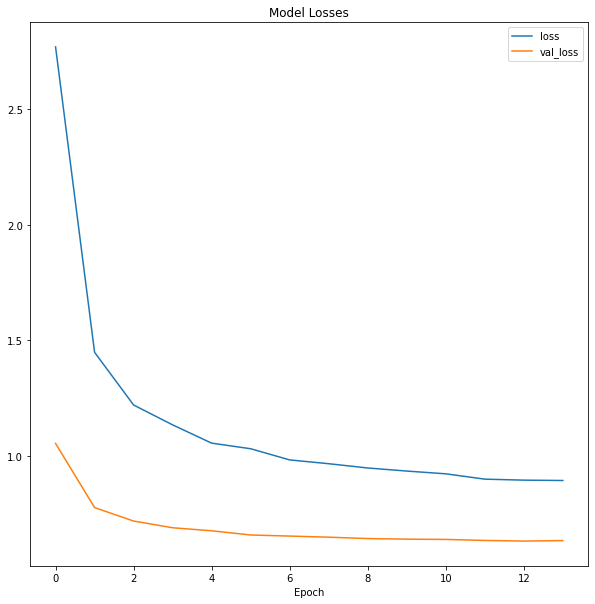

In [40]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [56]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.8097
top_5_accuracy    0.9680
precision         0.8118
recall            0.8067
f1_score          0.8066
loss              0.6446
Name: InceptionV3, dtype: float64

##### InceptionResNetV2

In [57]:
backbone_model = "InceptionResNetV2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_11  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_22 (Dropout)        (None, 1536)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               393472    
                                                                 
 batch_normalization_308 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                 

In [58]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

InceptionResNetV2 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/InceptionResNetV2.h5


82/82 [==============================] - 11s 136ms/step - loss: 0.5418 - accuracy: 0.8436 - top_k_categorical_accuracy: 0.9759


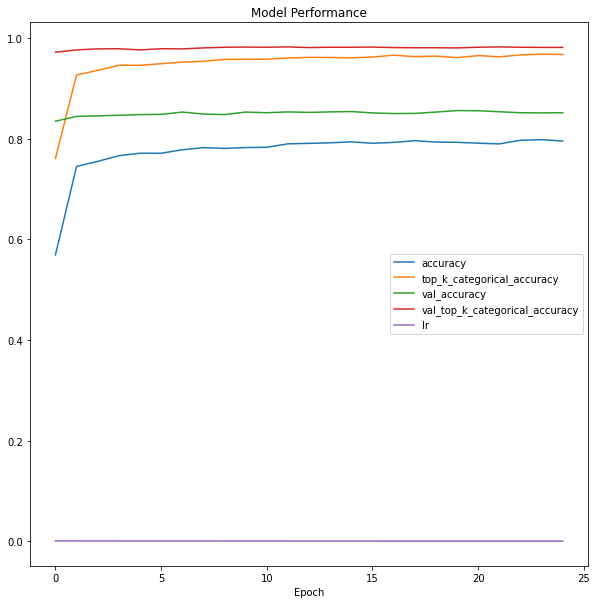

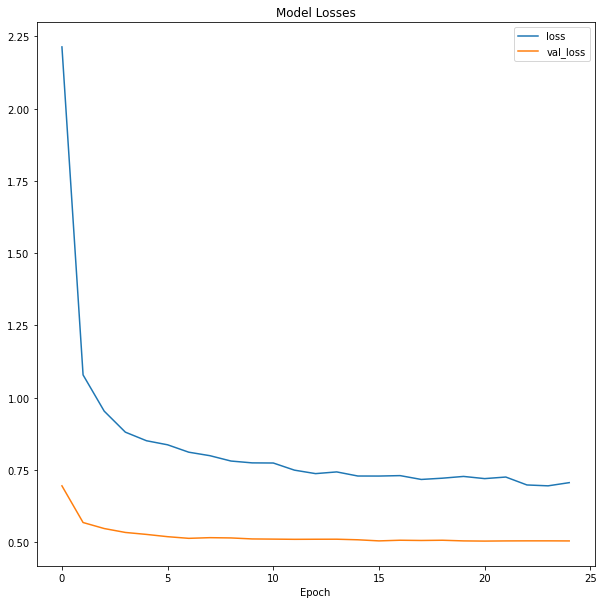

In [44]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [59]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.8436
top_5_accuracy    0.9759
precision         0.8436
recall            0.8409
f1_score          0.8396
loss              0.5300
Name: InceptionResNetV2, dtype: float64

##### Xception

In [60]:
backbone_model = "Xception"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_313 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_309 (Activation)  (None, 256)              0  

In [61]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

Xception model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/Xception.h5


82/82 [==============================] - 8s 96ms/step - loss: 0.6717 - accuracy: 0.8078 - top_k_categorical_accuracy: 0.9636


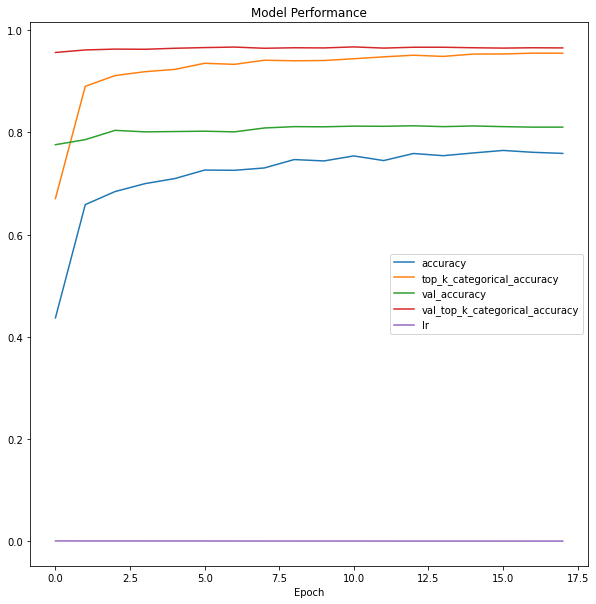

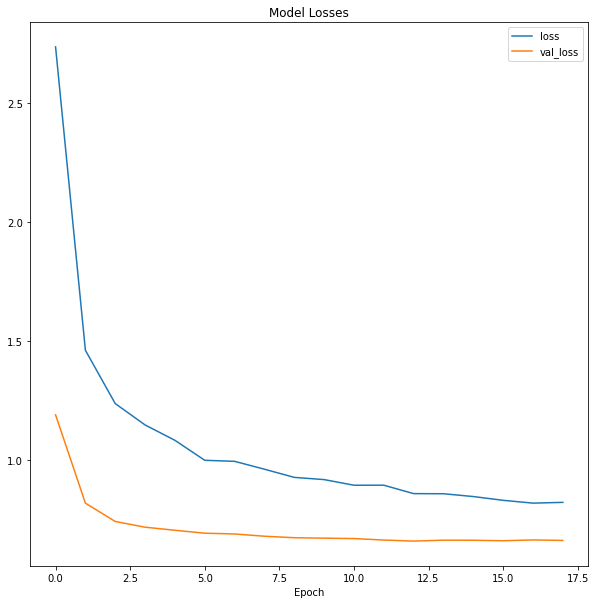

In [38]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [62]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.8064
top_5_accuracy    0.9636
precision         0.8095
recall            0.8035
f1_score          0.8032
loss              0.6610
Name: Xception, dtype: float64

##### DenseNet121

In [63]:
backbone_model = "DenseNet121"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_13  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_26 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_314 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_310 (Activation)  (None, 256)              

In [64]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenseNet121 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/DenseNet121.h5


82/82 [==============================] - 8s 92ms/step - loss: 0.7990 - accuracy: 0.7613 - top_k_categorical_accuracy: 0.9605


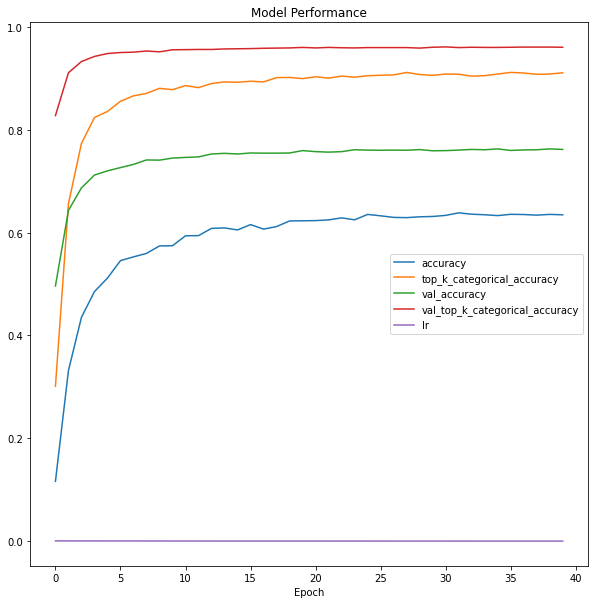

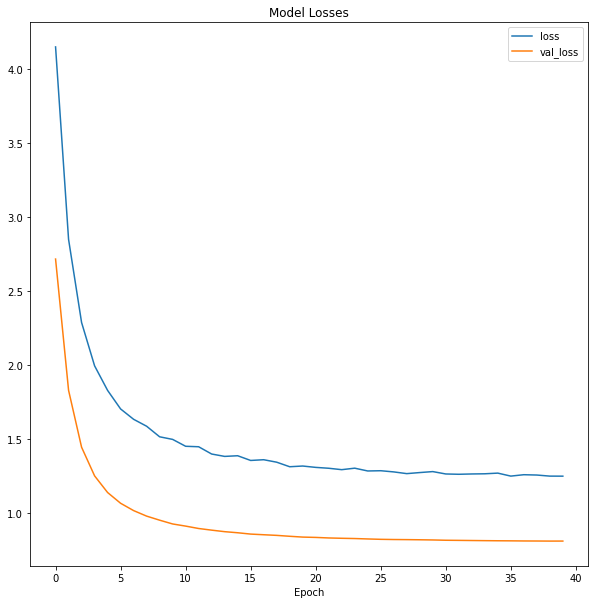

In [16]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [65]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7621
top_5_accuracy    0.9610
precision         0.7648
recall            0.7580
f1_score          0.7570
loss              0.7937
Name: DenseNet121, dtype: float64

##### DenseNet169

In [67]:
backbone_model = "DenseNet169"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "DenseNet169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_14  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_28 (Dropout)        (None, 1664)              0         
                                                                 
 dense_28 (Dense)            (None, 256)               426240    
                                                                 
 batch_normalization_315 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_311 (Activation)  (None, 256)              

In [68]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenseNet169 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/DenseNet169.h5


82/82 [==============================] - 8s 101ms/step - loss: 0.6755 - accuracy: 0.7977 - top_k_categorical_accuracy: 0.9682


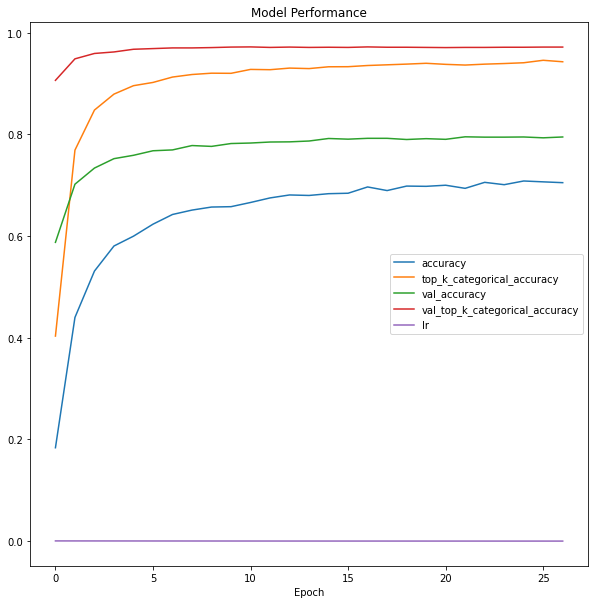

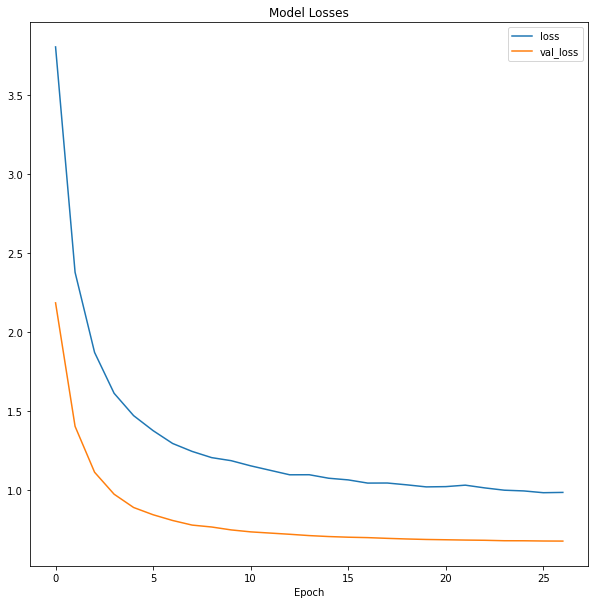

In [20]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [69]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7946
top_5_accuracy    0.9682
precision         0.7974
recall            0.7908
f1_score          0.7899
loss              0.6756
Name: DenseNet169, dtype: float64

##### DenseNet201

In [70]:
backbone_model = "DenseNet201"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_15  (None, 1920)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_30 (Dropout)        (None, 1920)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               491776    
                                                                 
 batch_normalization_316 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 activation_312 (Activation)  (None, 256)              

In [71]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

DenseNet201 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/DenseNet201.h5


82/82 [==============================] - 10s 126ms/step - loss: 0.6386 - accuracy: 0.8112 - top_k_categorical_accuracy: 0.9726


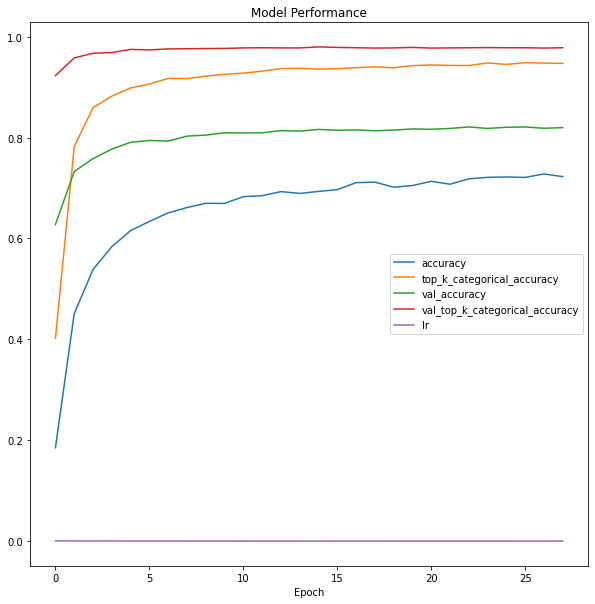

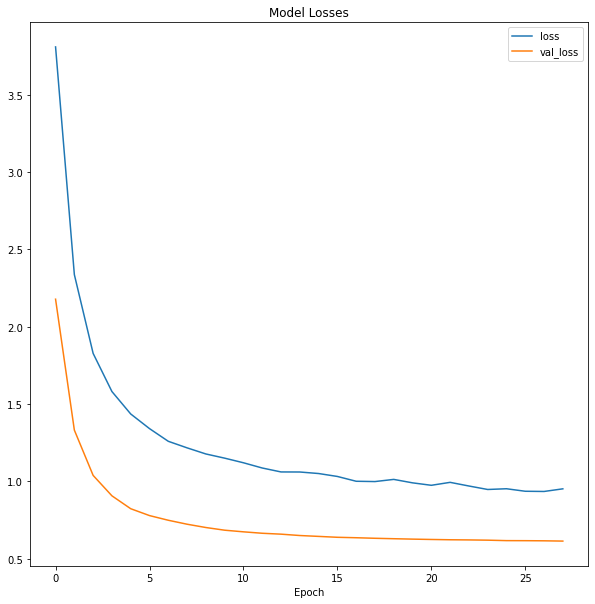

In [24]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [72]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.8108
top_5_accuracy    0.9711
precision         0.8131
recall            0.8075
f1_score          0.8070
loss              0.6397
Name: DenseNet201, dtype: float64

##### MobileNet

In [73]:
backbone_model = "MobileNet"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_16  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_32 (Dropout)        (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_317 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                         

In [74]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

MobileNet model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/MobileNet.h5


82/82 [==============================] - 6s 78ms/step - loss: 0.7813 - accuracy: 0.7694 - top_k_categorical_accuracy: 0.9649


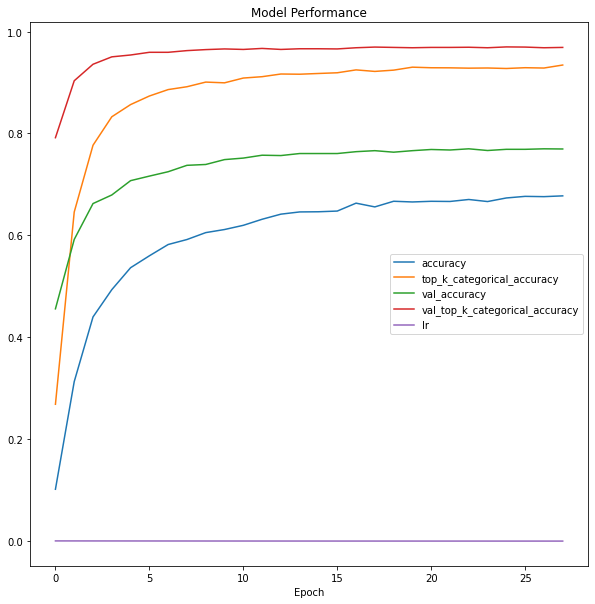

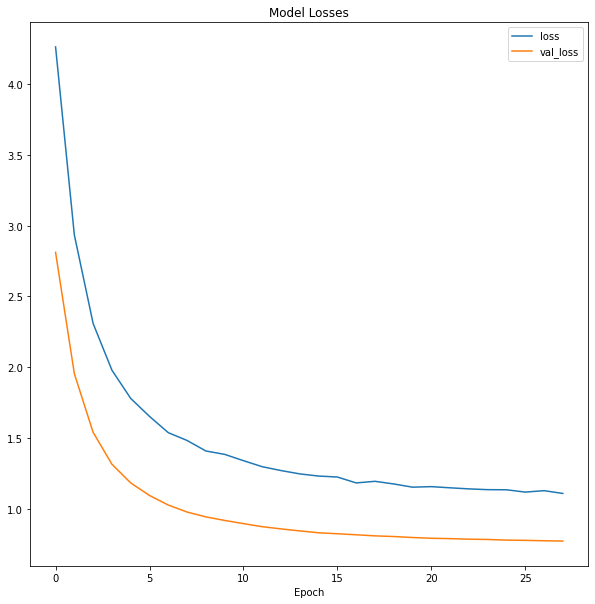

In [29]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [75]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7667
top_5_accuracy    0.9649
precision         0.7734
recall            0.7622
f1_score          0.7624
loss              0.7832
Name: MobileNet, dtype: float64

##### MobileNetV2

In [76]:
backbone_model = "MobileNetV2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            'top_k_categorical_accuracy',
            ]
        )
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_17  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_34 (Dropout)        (None, 1280)              0         
                                                                 
 dense_34 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_318 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                       

In [77]:
from tensorflow.keras.models import load_model

train_model = not (os.path.exists(MODEL_PATH / f"{model.name}.h5")) or TRAIN_MODELS

if train_model:
    history = model.fit(train_images, 
                        validation_data=val_images,
                        epochs=100, 
                        callbacks=callbacks,                        
    )
else:
    model_path = MODEL_PATH / f"{model.name}.h5"
    model = load_model(model_path)
    print(f"{model.name} model loaded from {model_path}")
    

MobileNetV2 model loaded from /home/vineet/.personal/code/Hello-CNN/Stanford Dogs/models/MobileNetV2.h5


82/82 [==============================] - 7s 79ms/step - loss: 0.8014 - accuracy: 0.7607 - top_k_categorical_accuracy: 0.9574


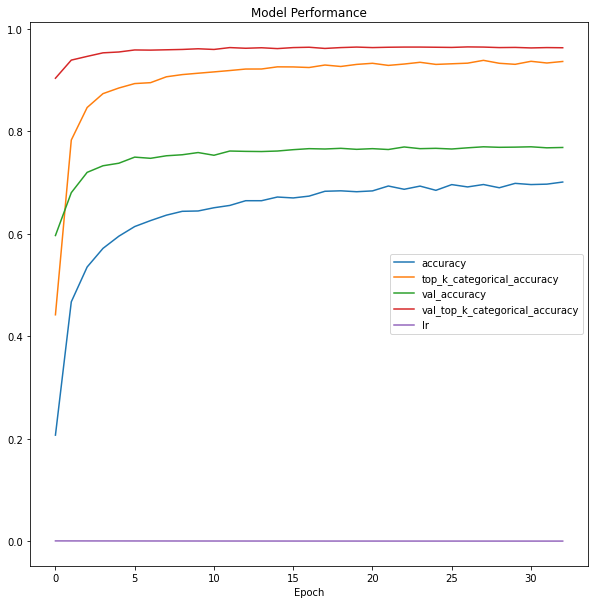

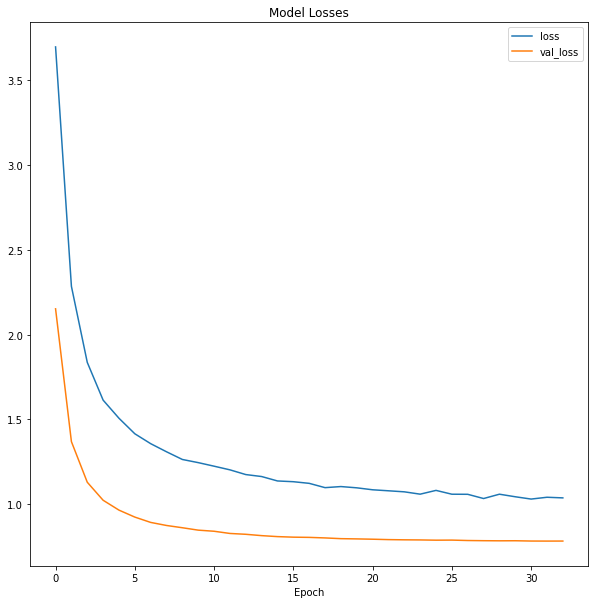

In [33]:
if train_model:
    model.evaluate(test_images)
    plot_model_performance(history)

In [78]:
test_images.shuffle = False
test_labels = test_images.labels
test_labels_pred_ohe = model.predict(test_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, True)

accuracy          0.7601
top_5_accuracy    0.9574
precision         0.7644
recall            0.7565
f1_score          0.7560
loss              0.7921
Name: MobileNetV2, dtype: float64

In [79]:
performance_df.sort_values(by="accuracy", ascending=False)

,accuracy,top_5_accuracy,precision,recall,f1_score,loss
InceptionResNetV2,0.8436,0.9759,0.8436,0.8409,0.8396,0.5300
DenseNet201,0.8108,0.9711,0.8131,0.8075,0.8070,0.6397
InceptionV3,0.8097,0.9680,0.8118,0.8067,0.8066,0.6446
Xception,0.8064,0.9636,0.8095,0.8035,0.8032,0.6610
DenseNet169,0.7946,0.9682,0.7974,0.7908,0.7899,0.6756
ResNet152V2,0.7809,0.9607,0.7838,0.7770,0.7766,0.7159
MobileNet,0.7667,0.9649,0.7734,0.7622,0.7624,0.7832
ResNet101V2,0.7665,0.9587,0.7700,0.7617,0.7612,0.7771
DenseNet121,0.7621,0.9610,0.7648,0.7580,0.7570,0.7937
MobileNetV2,0.7601,0.9574,0.7644,0.7565,0.7560,0.7921
